In [59]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

### **DATASET (PATHS)**

In [60]:
#Dataset Path:
DATASET_DIR = "dataset"

In [61]:
train_x = DATASET_DIR
test_y = DATASET_DIR

**Preprocessing for CNN**

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1563 images belonging to 4 classes.
Found 388 images belonging to 4 classes.


CNN **MODEL**

In [63]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # output layer for the 4 classes we are working with
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.2474 - loss: 1.3888
CNN Test Accuracy: 0.24742268025875092


In [64]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stop])

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 743ms/step - accuracy: 0.4229 - loss: 1.2248 - val_accuracy: 0.4871 - val_loss: 1.1130
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.5573 - loss: 1.0123 - val_accuracy: 0.5284 - val_loss: 1.0233
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 661ms/step - accuracy: 0.6404 - loss: 0.8890 - val_accuracy: 0.6624 - val_loss: 0.8794
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.6660 - loss: 0.8521 - val_accuracy: 0.6314 - val_loss: 0.9243
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 652ms/step - accuracy: 0.6737 - loss: 0.8082 - val_accuracy: 0.6624 - val_loss: 0.8629
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 643ms/step - accuracy: 0.6929 - loss: 0.7759 - val_accuracy: 0.7371 - val_loss: 0.7047
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 648ms/step - accuracy: 0.6692 - loss: 0.7972 - val_accuracy: 0.6340 - val_loss: 0.8137
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.7179 - loss: 0.7430 - val_accu

In [65]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.7448 - loss: 0.7021
CNN Test Accuracy: 0.7448453903198242


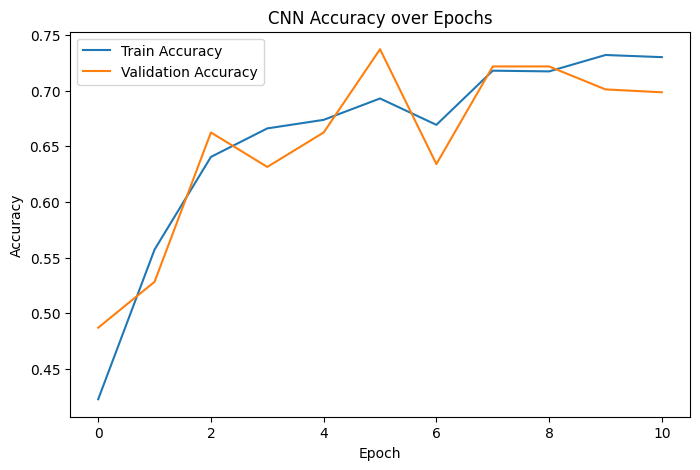

In [66]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

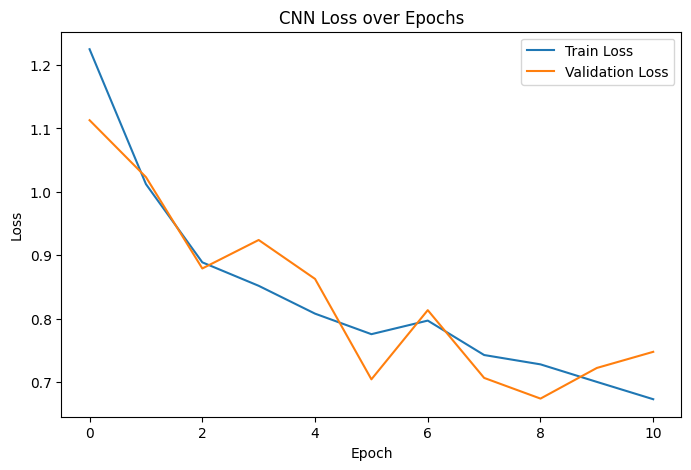

In [67]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Prepare features for **scikit-learn models**

In [97]:
feature_extractor = tf.keras.Sequential()
for layer in cnn_model.layers[:-2]:  # up to Dense(128)
    feature_extractor.add(layer)

def generator_to_arrays(generator):
    X_list, y_list = [], []

    for i in range(len(generator)):
        X_batch, y_batch = generator[i]

        # Extract CNN features instead of raw pixels, which makes both the RF and LR models better.
        features = feature_extractor.predict(X_batch, verbose=0)
        X_list.append(features)

        y_list.append(np.argmax(y_batch, axis=1))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    return X, y


X_train_flat, y_train_flat = generator_to_arrays(train_generator)
X_test_flat, y_test_flat = generator_to_arrays(test_generator)


**Logistic Regression**

In [98]:
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_flat, y_train_flat)
log_acc = accuracy_score(y_test_flat, log_model.predict(X_test_flat))
print("Logistic Regression Test Accuracy:", log_acc)

Logistic Regression Test Accuracy: 0.7268041237113402


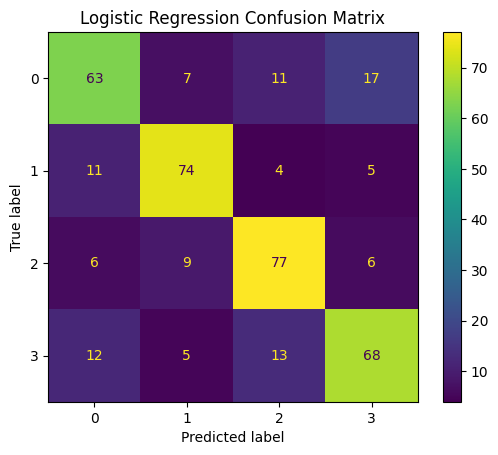

In [99]:
ConfusionMatrixDisplay.from_estimator(log_model, X_test_flat, y_test_flat)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

**Random Forest**

In [100]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_flat, y_train_flat)

rf_preds = rf_model.predict(X_test_flat)
rf_acc = accuracy_score(y_test_flat, rf_preds)
print("Random Forest Test Accuracy:", rf_acc)

Random Forest Test Accuracy: 0.7628865979381443


**Ensemble**

In [101]:
# CNN
cnn_probs = cnn_model.predict(test_generator)

# LR
log_probs = log_model.predict_proba(X_test_flat)

# RF
rf_probs = rf_model.predict_proba(X_test_flat)

# Soft Voting
cnn_conf = np.max(cnn_probs, axis=1)
ensemble_probs = 0.5*rf_probs + 0.25*log_probs + 0.25*cnn_probs
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# True labels
y_true = test_generator.classes

# Evaluate Ensemble
ensemble_acc = np.mean(ensemble_preds == y_true)
print("Ensemble Test Accuracy (Soft Voting):", ensemble_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step
Ensemble Test Accuracy (Soft Voting): 0.7422680412371134


**Accuracy list**

In [102]:
accuracy_list = [cnn_model.evaluate(test_generator)[1], log_acc, rf_acc, ensemble_acc]
models = ['CNN', 'Logistic Regression', 'Random Forest', 'Ensemble']

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step - accuracy: 0.7268 - loss: 0.7018


**bar chart**

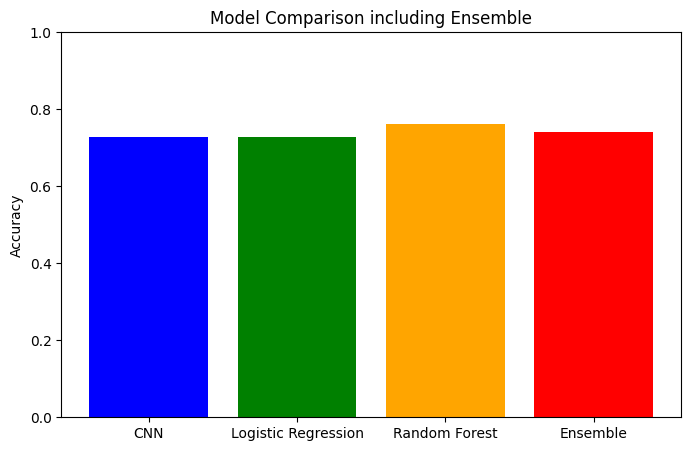

In [103]:
plt.figure(figsize=(8,5))
plt.bar(models, accuracy_list, color=['blue','green','orange','red'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Comparison including Ensemble")
plt.show()

**Comparison Table**

In [104]:
comparison = pd.DataFrame({
    "Model": ["Simple CNN", "Logistic Regression", "Random Forest", "Ensemble"],
    "Test Accuracy": [cnn_acc, log_acc, rf_acc, ensemble_acc],
    "Error Rate": [1-cnn_acc, 1-log_acc, 1-rf_acc, 1-ensemble_acc]
})
print("\nComparison Table:")
print(comparison)


Comparison Table:
                 Model  Test Accuracy  Error Rate
0           Simple CNN       0.744845    0.255155
1  Logistic Regression       0.726804    0.273196
2        Random Forest       0.762887    0.237113
3             Ensemble       0.742268    0.257732


In [105]:
# CNN
cnn_model.save("models/cnn_model.keras")

# Logistic Regression & Random Forest
import joblib
joblib.dump(log_model, "models/log_model.pkl")
joblib.dump(rf_model, "models/rf_model.pkl")

['models/rf_model.pkl']